# DIOR-R Rotated Object Detection (YOLO OBB) — Colab + KaggleHub

This notebook runs on Google Colab and downloads the **DIOR-R** dataset with **KaggleHub**,
prepares it in **YOLO-OBB** format, trains the **YOLOv8 OBB** model, performs evaluation (mAP),
and saves the final weights to **Google Drive**.

## Steps
1) Connecting to Google Drive and checking the GPU
2) Installing libraries (Ultralytics, KaggleHub, …)
3) Key settings
4) Download dataset with KaggleHub
5) Preparing the dataset structure for YOLO-OBB
6) Creating the data.yaml file
7) trairning YOLOv8s OBB model
8) Validate / mAP
9) Predicting samples and saving images , Angle-wise Analysis (Precision/Recall vs Angle)
10) saving all files and results


## 1) Connecting to Google Drive and checking the GPU

In [ ]:
import torch, os
from google.colab import drive

print('PyTorch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))

drive.mount('/content/drive', force_remount=True)

PyTorch: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA L4
Mounted at /content/drive


## 2) Installing libraries

In [ ]:
!pip -q install --upgrade ultralytics>=8.2.0 kagglehub shapely albumentations pycocotools tqdm opencv-python pyyaml lxml
from ultralytics import YOLO
import kagglehub, os, shutil, glob, json, random, time
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch
import itertools

print('Ultralytics & KaggleHub imported.')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics & KaggleHub imported.


## 3) Key settings

In [ ]:
# اندازه مدل: 'n' (خیلی سبک), 's' (سبک), 'm' (متوسط)
MODEL_SIZE = 's'  # 'n' | 's' | 'm'

# آیا اگر GPU در دسترس نبود، روی CPU اجرا شود؟
FALLBACK_TO_CPU = True

# مسیر ذخیره وزن‌ها در Google Drive
DRIVE_SAVE_DIR = Path('/content/drive/MyDrive/diorr_obb_runs')
DRIVE_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# اندازه ورودی/ایپوک/بچ — برای Colab GPU معمولاً مناسب‌اند
IMGSZ = 1024
EPOCHS = 10
BATCH = 16

# اگر می‌خواهید سریع‌تر شروع کنید، می‌توانید از زیرمجموعه استفاده کنید (0<ratio<=1)
SUBSET_RATIO = 1.0  # برای کل داده 1.0

## 4) Download dataset with KaggleHub

In [ ]:
# Download latest version
path = kagglehub.dataset_download("redzapdos123/dior-r-dataset-yolov11-obb-format")
print("Path to dataset files:", path)

RAW_PATH = Path(path)  # ریشه‌ی دیتاست دانلود شده
print('RAW_PATH contents:', [p.name for p in RAW_PATH.iterdir()][:10])

100%|██████████| 6.91G/6.91G [05:41<00:00, 21.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/redzapdos123/dior-r-dataset-yolov11-obb-format/versions/2
RAW_PATH contents: ['YOLODIOR-R']


In [ ]:
# اگر cell دانلود KaggleHub را اجرا کرده‌ای:
RAW_ROOT = Path(path) / "YOLODIOR-R"

# اگر path در دسترس نیست، این را بگذار (طبق لاگ تو):
# RAW_ROOT = Path("/root/.cache/kagglehub/datasets/redzapdos123/dior-r-dataset-yolov11-obb-format/versions/2/YOLODIOR-R")

assert RAW_ROOT.exists(), f"RAW_ROOT not found: {RAW_ROOT}"

TARGET = Path('/content/diorr_obb')
for p in [TARGET/'images'/'train', TARGET/'images'/'val', TARGET/'labels'/'train', TARGET/'labels'/'val']:
    p.mkdir(parents=True, exist_ok=True)

def copy_tree(src: Path, dst: Path):
    src = Path(src); dst = Path(dst)
    for p in src.rglob('*'):
        if p.is_file():
            (dst/p.relative_to(src)).parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(p, dst/p.relative_to(src))

def link_or_copy(src, dst, use_symlink=True):
    src, dst = Path(src), Path(dst)
    if dst.exists():
        if dst.is_symlink() or dst.is_file():
            dst.unlink()
        elif dst.is_dir():
            shutil.rmtree(dst)
    dst.parent.mkdir(parents=True, exist_ok=True)
    if use_symlink:
        dst.symlink_to(src, target_is_directory=True)
    else:
        copy_tree(src, dst)

# ---- کشف ساختار ----
cands = {
    "A": [RAW_ROOT/'images'/'train', RAW_ROOT/'images'/'val', RAW_ROOT/'labels'/'train', RAW_ROOT/'labels'/'val'],
    "B": [RAW_ROOT/'train'/'images', RAW_ROOT/'val'/'images', RAW_ROOT/'train'/'labels', RAW_ROOT/'val'/'labels'],
    "B2":[RAW_ROOT/'train'/'images', RAW_ROOT/'valid'/'images', RAW_ROOT/'train'/'labels', RAW_ROOT/'valid'/'labels'],
    "C": [RAW_ROOT/'images', RAW_ROOT/'labels'],  # بدون اسپلیت
}

mode = None
for k, reqs in cands.items():
    if all(p.exists() for p in reqs):
        mode = k
        found = reqs
        break

print("Detected mode:", mode, "Roots:", found if mode else "N/A")

# ---- نگاشت به TARGET ----
if mode == "A":
    link_or_copy(found[0], TARGET/'images'/'train')
    link_or_copy(found[1], TARGET/'images'/'val')
    link_or_copy(found[2], TARGET/'labels'/'train')
    link_or_copy(found[3], TARGET/'labels'/'val')
elif mode in ("B","B2"):
    link_or_copy(found[0], TARGET/'images'/'train')
    link_or_copy(found[1], TARGET/'images'/'val')
    link_or_copy(found[2], TARGET/'labels'/'train')
    link_or_copy(found[3], TARGET/'labels'/'val')
elif mode == "C":
    # خودمان 85/15 تقسیم می‌کنیم
    imgs = []
    for ext in ('*.jpg','*.jpeg','*.png'):
        imgs += list(found[0].rglob(ext))
    lbls = list(found[1].rglob('*.txt'))
    img_map = {p.stem: p for p in imgs}
    lbl_map = {p.stem: p for p in lbls}
    keys = sorted(set(img_map.keys()) & set(lbl_map.keys()))
    random.shuffle(keys)
    val_n = max(50, int(0.15*len(keys)))
    val_keys = set(keys[:val_n])
    for k in keys:
        img = img_map[k]; lbl = lbl_map[k]
        if k in val_keys:
            shutil.copy2(img, TARGET/'images'/'val'/img.name)
            shutil.copy2(lbl, TARGET/'labels'/'val'/lbl.name)
        else:
            shutil.copy2(img, TARGET/'images'/'train'/img.name)
            shutil.copy2(lbl, TARGET/'labels'/'train'/lbl.name)
else:
    # fallback: تلاش برای پیدا کردن هر نوع ساختار دیگر (train*/val*/valid*)
    def find_dir(root: Path, name_opts):
        for name in name_opts:
            p = root / name
            if p.exists(): return p
        # جستجوی بازگشتی
        for p in root.rglob('*'):
            if p.is_dir() and p.name in name_opts:
                return p
        return None

    # تلاش: train/images, val/images, train/labels, val/labels با نام‌های جایگزین
    train_root = find_dir(RAW_ROOT, ['train', 'Train', 'training'])
    val_root   = find_dir(RAW_ROOT, ['val', 'valid', 'validation', 'Val', 'Valid'])
    if train_root and val_root:
        tr_imgs = find_dir(train_root, ['images', 'Images'])
        tr_lbls = find_dir(train_root, ['labels', 'Labels'])
        va_imgs = find_dir(val_root,   ['images', 'Images'])
        va_lbls = find_dir(val_root,   ['labels', 'Labels'])
        assert tr_imgs and tr_lbls and va_imgs and va_lbls, "ساختار train/val پیدا شد ولی images/labels موجود نیست."
        link_or_copy(tr_imgs, TARGET/'images'/'train')
        link_or_copy(va_imgs, TARGET/'images'/'val')
        link_or_copy(tr_lbls, TARGET/'labels'/'train')
        link_or_copy(va_lbls, TARGET/'labels'/'val')
    else:
        raise AssertionError("ساختار دیتاست شناسایی نشد. لطفاً محتویات RAW_ROOT را print کنید تا مسیر دقیق را تنظیم کنیم.")

print('Prepared dataset at:', TARGET)
print('Train imgs:', len(list((TARGET/'images'/'train').glob('*'))))
print('Val imgs:',   len(list((TARGET/'images'/'val').glob('*'))))
print('Train lbls:', len(list((TARGET/'labels'/'train').glob('*.txt'))))
print('Val lbls:',   len(list((TARGET/'labels'/'val').glob('*.txt'))))


Detected mode: B Roots: [PosixPath('/root/.cache/kagglehub/datasets/redzapdos123/dior-r-dataset-yolov11-obb-format/versions/2/YOLODIOR-R/train/images'), PosixPath('/root/.cache/kagglehub/datasets/redzapdos123/dior-r-dataset-yolov11-obb-format/versions/2/YOLODIOR-R/val/images'), PosixPath('/root/.cache/kagglehub/datasets/redzapdos123/dior-r-dataset-yolov11-obb-format/versions/2/YOLODIOR-R/train/labels'), PosixPath('/root/.cache/kagglehub/datasets/redzapdos123/dior-r-dataset-yolov11-obb-format/versions/2/YOLODIOR-R/val/labels')]
Prepared dataset at: /content/diorr_obb
Train imgs: 18770
Val imgs: 2346
Train lbls: 18770
Val lbls: 2346


## 5) Preparing the dataset structure for YOLO-OBB

In [ ]:
# هدف: ایجاد ساختار استاندارد YOLO-OBB:
# /content/diorr_obb/
#   images/train, images/val
#   labels/train, labels/val

TARGET = Path('/content/diorr_obb')
for p in [TARGET/'images'/'train', TARGET/'images'/'val', TARGET/'labels'/'train', TARGET/'labels'/'val']:
    p.mkdir(parents=True, exist_ok=True)

# تلاش برای حدس ساختار دیتاست KaggleHub:
# بسیاری از پکیج‌های YOLO آماده این ساختار را دارند: images/{train,val} و labels/{train,val}
# ما به صورت ایمن، اگر این ساختار یافت شد همان را کپی می‌کنیم؛
# اگر test هم بود نادیده می‌گیریم یا بعداً استفاده می‌کنیم.

def copy_tree(src, dst):
    src = Path(src); dst = Path(dst)
    for p in src.rglob('*'):
        if p.is_file():
            rel = p.relative_to(src)
            (dst/rel).parent.mkdir(parents=True, exist_ok=True)
            shutil.copy(p, dst/rel)

images_train = list(RAW_PATH.rglob('images/train'))
images_val   = list(RAW_PATH.rglob('images/val'))
labels_train = list(RAW_PATH.rglob('labels/train'))
labels_val   = list(RAW_PATH.rglob('labels/val'))

if images_train and images_val and labels_train and labels_val:
    # ساختار آماده است؛ فقط کپی می‌کنیم
    print('Detected YOLO-style split folders; copying...')
    copy_tree(images_train[0], TARGET/'images'/'train')
    copy_tree(images_val[0],   TARGET/'images'/'val')
    copy_tree(labels_train[0], TARGET/'labels'/'train')
    copy_tree(labels_val[0],   TARGET/'labels'/'val')
else:
    # fallback: جستجو برای تمام تصاویر و لیبل‌ها در یکجا
    print('YOLO split folders not found clearly; falling back to flat copy...')
    # تصاویر
    img_exts = ('*.jpg','*.jpeg','*.png')
    imgs = []
    for ext in img_exts:
        imgs += list(RAW_PATH.rglob(ext))
    # برچسب‌ها
    lbls = list(RAW_PATH.rglob('*.txt'))

    # نگاشت نام فایل‌ها
    img_map = {p.stem: p for p in imgs}
    lbl_map = {p.stem: p for p in lbls}

    keys = sorted(set(img_map.keys()) & set(lbl_map.keys()))
    random.shuffle(keys)
    val_n = max(50, int(0.15*len(keys)))  # 15% برای val
    val_keys = set(keys[:val_n])

    for k in keys:
        img = img_map[k]; lbl = lbl_map[k]
        if k in val_keys:
            shutil.copy(img, TARGET/'images'/'val'/img.name)
            shutil.copy(lbl, TARGET/'labels'/'val'/lbl.name)
        else:
            shutil.copy(img, TARGET/'images'/'train'/img.name)
            shutil.copy(lbl, TARGET/'labels'/'train'/lbl.name)

print('Prepared dataset at:', TARGET)
print('Train imgs:', len(list((TARGET/'images'/'train').glob('*'))))
print('Val imgs:', len(list((TARGET/'images'/'val').glob('*'))))

### Quickly check the format of OBB labels

In [ ]:
# فرمت مورد انتظار هر خط لیبل: class_id x1 y1 x2 y2 x3 y3 x4 y4  (مقدارها نرمالایز شده 0..1)
# چند فایل را بررسی می‌کنیم:
import itertools

def check_label_file(fp, max_lines=3):
    ok = True
    with open(fp, 'r') as f:
        for i, line in enumerate(f):
            parts = line.strip().split()
            if len(parts) != 9:
                ok = False; break
            # اولین مقدار باید عدد کلاس باشد
            try:
                int(parts[0])
                coords = list(map(float, parts[1:]))
                if len(coords) != 8:
                    ok = False; break
            except:
                ok = False; break
            if i+1 >= max_lines:
                break
    return ok

sample_labels = list((TARGET/'labels'/'train').glob('*.txt'))[:10]
if sample_labels:
    res = [check_label_file(p) for p in sample_labels]
    print('Sample label files OK?:', all(res), f'Checked {len(sample_labels)} files')
else:
    print('No label files found to check!')

## 6) Creating the data.yaml file

In [ ]:
DATA_DIR = Path('/content/diorr_obb')
NAMES = [
    'airplane','airport','baseballfield','basketballcourt','bridge','chimney','dam','Expressway-Service-area',
    'Expressway-toll-station','golffield','groundtrackfield','harbor','ship','overpass','stadium','storagetank',
    'tenniscourt','trainstation','vehicle','windmill'
]

DATA_YAML = DATA_DIR/'data.yaml'
yaml_text = f"""path: {DATA_DIR}
train: images/train
val: images/val
task: obb
names: {NAMES}
"""
with open(DATA_YAML, 'w') as f:
    f.write(yaml_text)

print('Wrote data.yaml at:', DATA_YAML)


Wrote data.yaml at: /content/diorr_obb/data.yaml


In [ ]:
# مسیرهایی که می‌خواهی حفظ شوند:
PROJECTS = [
    "/content/diorr_obb",
]

SAVE_ROOT = "/content/drive/MyDrive/colab_diorr_obb"
os.makedirs(SAVE_ROOT, exist_ok=True)

for p in PROJECTS:
    if os.path.exists(p):
        name = pathlib.Path(p).name
        shutil.copytree(p, f"{SAVE_ROOT}/{name}", dirs_exist_ok=True)
        print("Backed up:", p, "→", f"{SAVE_ROOT}/{name}")
    else:
        print("Skip (not found):", p)


Mounted at /content/drive
Backed up: /content/diorr_obb → /content/drive/MyDrive/colab_diorr_obb/diorr_obb


## 7) trairning YOLOv8s OBB model

In [ ]:
weights_map = {'n':'yolov8n-obb.pt','s':'yolov8s-obb.pt','m':'yolov8m-obb.pt'}
MODEL_WEIGHTS = weights_map[MODEL_SIZE]

device = 'cpu'
if torch.cuda.is_available():
    device = 0
elif not torch.cuda.is_available() and not FALLBACK_TO_CPU:
    raise RuntimeError('GPU در دسترس نیست و FALLBACK_TO_CPU=False است.')

model = YOLO(MODEL_WEIGHTS)
run_name = f'diorr_obb_{MODEL_SIZE}_{int(time.time())}'

results = model.train(
    data=str((Path('/content/diorr_obb')/'data.yaml').resolve()),
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    device=device,
    workers=2 if device!= 'cpu' else 0,
    seed=42,
    optimizer='SGD',
    cos_lr=True,
    amp=(device!= 'cpu'),
    patience=15,
    name=run_name
)
print('Training finished.')

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/diorr_obb/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-obb.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=diorr_obb_s_1760356477, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=15, perspective=0.0, p

## 8) Validate / mAP

In [ ]:
val_res = model.val(
    data=str((Path('/content/diorr_obb')/'data.yaml').resolve()),
    imgsz=IMGSZ,
    device=0 if (hasattr(model, 'overrides') and torch.cuda.is_available()) else 'cpu',
    split='val'
)
print(val_res)

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv8s-obb summary (fused): 81 layers, 11,419,311 parameters, 0 gradients, 29.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1817.3±1003.8 MB/s, size: 275.0 KB)
val: Scanning /content/diorr_obb/labels/val.cache... 3519 images, 0 backgrounds, 29 corrupt: 100% ━━━━━━━━━━━━ 3519/3519 4.6Mit/s 0.0s
val: /content/diorr_obb/images/val/00433.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0225]
val: /content/diorr_obb/images/val/01367.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0288]
val: /content/diorr_obb/images/val/03805.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0375      1.0163]
val: /content/diorr_obb/images/val/04145.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.03]
val: /content/diorr_obb/images/val/04278.jpg: ignoring corr

In [ ]:
res = model.val(data=str((Path('/content/diorr_obb')/'data.yaml').resolve()),
                imgsz=IMGSZ, device=0 if torch.cuda.is_available() else 'cpu', split='val', save_json=False)
# اگر res.metrics.per_class در نسخه فعلی در دسترس نبود، از خروجی چاپ‌شده لاگ بگیر
try:
    names = res.names  # dict: id->name
    ap50_95 = res.box.map  # یا res.metrics.ap
    ap50    = res.box.map50
    # بسته به نسخه Ultralytics، استخراج per-class کمی فرق دارد؛
    # اگر موجود بود:
    per_class = getattr(res, 'results_dict', None)
    print('Done. Check printed metrics above.')
except Exception as e:
    print('Per-class AP depends on Ultralytics version; fallback to printed logs.', e)


Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2929.9±1373.5 MB/s, size: 263.5 KB)
val: Scanning /root/.cache/kagglehub/datasets/redzapdos123/dior-r-dataset-yolov11-obb-format/versions/2/YOLODIOR-R/val/labels... 2346 images, 0 backgrounds, 17 corrupt: 100% ━━━━━━━━━━━━ 2346/2346 988.8it/s 2.4s
val: /root/.cache/kagglehub/datasets/redzapdos123/dior-r-dataset-yolov11-obb-format/versions/2/YOLODIOR-R/val/images/01045.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1337        1.22]
val: /root/.cache/kagglehub/datasets/redzapdos123/dior-r-dataset-yolov11-obb-format/versions/2/YOLODIOR-R/val/images/01892.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.075]
val: /root/.cache/kagglehub/datasets/redzapdos123/dior-r-dataset-yolov11-obb-format/versions/2/YOLODIOR-R/val/images/02551.jpg: ignoring corrupt image/label: non-normalized o

## 9) Predicting samples and saving images , Angle-wise Analysis (Precision/Recall vs Angle)

In [ ]:
SAMPLES = list((Path('/content/diorr_obb')/'images'/'val').glob('*'))[:12]
save_dir = Path('viz_results'); save_dir.mkdir(exist_ok=True)

for p in SAMPLES:
    r = model.predict(source=str(p), device=0 if torch.cuda.is_available() else 'cpu', imgsz=1024, conf=0.25, verbose=False)[0]
    plot = r.plot()
    cv2.imwrite(str(save_dir / f'{p.stem}_pred.jpg'), plot[:, :, ::-1])

print('Saved predictions to:', str(save_dir.resolve()))

Saved predictions to: /content/viz_results


In [ ]:
DATA_DIR = Path('/content/diorr_obb')
VAL_IMGS = sorted((DATA_DIR/'images'/'val').glob('*'))
VAL_LBLS = DATA_DIR/'labels'/'val'

def load_labels(fp):
    items=[]
    with open(fp,'r') as f:
        for ln in f:
            p=ln.strip().split()
            if len(p)!=9: continue  # cls + 8 coords
            items.append((int(p[0]), list(map(float, p[1:]))))
    return items

def unnorm(poly,w,h):
    out=[];
    for i,v in enumerate(poly): out.append(v*w if i%2==0 else v*h)
    return out

def poly_angle_deg(poly):
    pts=np.array(poly,dtype=float).reshape(-1,2)
    edges=np.roll(pts,-1,axis=0)-pts
    i=int(np.argmax(np.linalg.norm(edges,axis=1)))
    vx,vy=edges[i]
    return (np.degrees(np.arctan2(vy,vx))%180.0)

def iou_poly(p1,p2):
    W=H=512
    m1=np.zeros((H,W),np.uint8); m2=np.zeros((H,W),np.uint8)
    def draw(m,poly):
        pts=np.array(poly,dtype=np.int32).reshape(-1,2)
        cv2.fillPoly(m,[pts],255)
    draw(m1,p1); draw(m2,p2)
    inter=np.logical_and(m1,m2).sum(); union=np.logical_or(m1,m2).sum()
    return inter/union if union>0 else 0.0

angle_bins=[(0,30),(30,60),(60,90),(90,120),(120,150),(150,180)]
bin_hits={b:{'tp':0,'fp':0,'fn':0} for b in angle_bins}

# برای سرعت، 200–300 تصویر کافی است؛ اگر خواستی همه را بردار
subset = VAL_IMGS[:250]

device = 0 if torch.cuda.is_available() else 'cpu'
for imgp in tqdm(subset, desc="Angle-wise eval"):
    im=cv2.imread(str(imgp)); h,w=im.shape[:2]
    gt_path=VAL_LBLS/(imgp.stem+'.txt')
    if not gt_path.exists(): continue
    gt=load_labels(gt_path)
    gt_polys=[(cid,unnorm(poly,w,h),poly_angle_deg(unnorm(poly,w,h))) for cid,poly in gt]

    r=model.predict(source=str(imgp), device=device, imgsz=IMGSZ, conf=0.25, verbose=False)[0]
    pred=[]
    if hasattr(r,'obb') and hasattr(r.obb,'xyxyxyxy'):
        for b in r.obb.xyxyxyxy:
            poly=b.cpu().numpy().reshape(-1).tolist()
            ang=poly_angle_deg(poly)
            pred.append((0,poly,ang))

    matched=set()
    for pcid,ppoly,pang in pred:
        best_i,best_j=0.0,-1
        for j,(gcid,gpoly,gang) in enumerate(gt_polys):
            if j in matched: continue
            iou=iou_poly(ppoly,gpoly)
            if iou>best_i: best_i,best_j=iou,j
        # bin با زاویه‌ی پیش‌بینی‌شده
        bkey=None
        for lo,hi in angle_bins:
            if lo<=pang<hi: bkey=(lo,hi); break
        if bkey is None: continue
        if best_i>=0.2 and best_j not in matched:
            bin_hits[bkey]['tp']+=1; matched.add(best_j)
        else:
            bin_hits[bkey]['fp']+=1

    for j in range(len(gt_polys)):
        if j not in matched:
            g_ang=gt_polys[j][2]
            for lo,hi in angle_bins:
                if lo<=g_ang<hi: bin_hits[(lo,hi)]['fn']+=1; break

rows=[]
for b in angle_bins:
    tp=bin_hits[b]['tp']; fp=bin_hits[b]['fp']; fn=bin_hits[b]['fn']
    prec=tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec =tp/(tp+fn) if (tp+fn)>0 else 0.0
    rows.append({'angle_bin':f'{b[0]}–{b[1]}','TP':tp,'FP':fp,'FN':fn,'Precision':prec,'Recall':rec})
df=pd.DataFrame(rows)
df


Angle-wise eval: 100%|██████████| 250/250 [00:31<00:00,  7.95it/s]


,angle_bin,TP,FP,FN,Precision,Recall
0,0–30,140,127,111,0.524345,0.557769
1,30–60,239,189,171,0.558411,0.582927
2,60–90,141,165,72,0.460784,0.661972
3,90–120,194,162,198,0.544944,0.494898
4,120–150,44,31,37,0.586667,0.543210
5,150–180,82,85,37,0.491018,0.689076


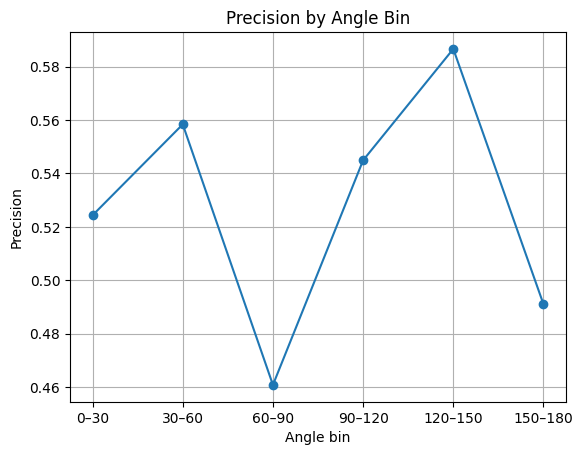

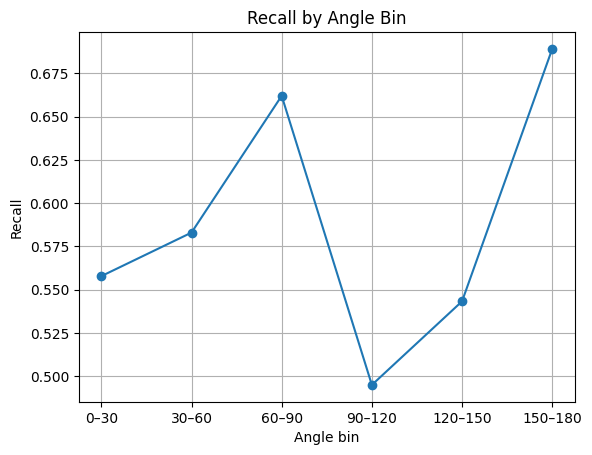

Saved analysis to: /content/drive/MyDrive/diorr_obb_analysis


In [ ]:
plt.figure(); plt.plot(df['angle_bin'], df['Precision'], marker='o')
plt.title('Precision by Angle Bin'); plt.grid(True); plt.xlabel('Angle bin'); plt.ylabel('Precision'); plt.show()

plt.figure(); plt.plot(df['angle_bin'], df['Recall'], marker='o')
plt.title('Recall by Angle Bin'); plt.grid(True); plt.xlabel('Angle bin'); plt.ylabel('Recall'); plt.show()

out_dir = Path('/content/drive/MyDrive/diorr_obb_analysis')
out_dir.mkdir(parents=True, exist_ok=True)
df.to_csv(out_dir/'angle_wise_metrics.csv', index=False)
plt.figure(); plt.plot(df['angle_bin'], df['Precision'], marker='o'); plt.grid(True); plt.savefig(out_dir/'precision_by_angle.png'); plt.close()
plt.figure(); plt.plot(df['angle_bin'], df['Recall'], marker='o');    plt.grid(True); plt.savefig(out_dir/'recall_by_angle.png');    plt.close()

print('Saved analysis to:', out_dir)


In [ ]:
def draw_poly(img, poly, color, w=2):
    pts=np.array(poly,dtype=np.int32).reshape(-1,2)
    cv2.polylines(img,[pts],True,color,w)

def collect_fp_fn(n_pick=10):
    stats=[]
    device = 0 if torch.cuda.is_available() else 'cpu'
    for imgp in tqdm(subset, desc='Scoring FP/FN'):
        im=cv2.imread(str(imgp)); h,w=im.shape[:2]
        gt_path=VAL_LBLS/(imgp.stem+'.txt')
        if not gt_path.exists(): continue
        gt=load_labels(gt_path)
        gt_polys=[unnorm(poly,w,h) for _,poly in gt]

        r=model.predict(source=str(imgp), device=device, imgsz=IMGSZ, conf=0.25, verbose=False)[0]
        preds=[b.cpu().numpy().reshape(-1).tolist() for b in getattr(r.obb,'xyxyxyxy',[])]
        # match ساده
        matched_gt=set(); tp=0; fp=0
        for ppoly in preds:
            ok=False
            for j,gpoly in enumerate(gt_polys):
                if j in matched_gt: continue
                if iou_poly(ppoly,gpoly)>=0.2:
                    matched_gt.add(j); ok=True; break
            if ok: tp+=1
            else:  fp+=1
        fn = max(0, len(gt_polys)-len(matched_gt))
        stats.append((imgp, tp, fp, fn))
    # انتخاب worst نمونه‌ها
    worst_fp = sorted(stats, key=lambda x: x[2], reverse=True)[:n_pick]
    worst_fn = sorted(stats, key=lambda x: x[3], reverse=True)[:n_pick]
    return worst_fp, worst_fn

worst_fp, worst_fn = collect_fp_fn(n_pick=10)

save_fp = Path('/content/drive/MyDrive/diorr_obb_analysis/FP_samples'); save_fp.mkdir(parents=True, exist_ok=True)
save_fn = Path('/content/drive/MyDrive/diorr_obb_analysis/FN_samples'); save_fn.mkdir(parents=True, exist_ok=True)

def save_annotated(samples, out_dir, tag):
    device = 0 if torch.cuda.is_available() else 'cpu'
    for imgp, tp, fp, fn in samples:
        im = cv2.imread(str(imgp))
        h,w=im.shape[:2]
        gt_path=VAL_LBLS/(imgp.stem+'.txt')
        gt=load_labels(gt_path)
        gt_polys=[unnorm(poly,w,h) for _,poly in gt]
        r = model.predict(source=str(imgp), device=device, imgsz=IMGSZ, conf=0.25, verbose=False)[0]
        preds=[b.cpu().numpy().reshape(-1).tolist() for b in getattr(r.obb,'xyxyxyxy',[])]

        canvas = im.copy()
        for g in gt_polys:  draw_poly(canvas,g,(0,255,0),2)   # GT سبز
        for p in preds:     draw_poly(canvas,p,(0,0,255),2)   # Pred قرمز

        cv2.putText(canvas, f'TP:{tp} FP:{fp} FN:{fn}', (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,0), 2, cv2.LINE_AA)
        cv2.imwrite(str(out_dir / f'{imgp.stem}_{tag}.jpg'), canvas[:,:,::-1])

save_annotated(worst_fp, save_fp, 'FP')
save_annotated(worst_fn, save_fn, 'FN')
print('Saved FP/FN samples to:', save_fp, 'and', save_fn)


Scoring FP/FN: 100%|██████████| 250/250 [00:22<00:00, 11.29it/s]


Saved FP/FN samples to: /content/drive/MyDrive/diorr_obb_analysis/FP_samples and /content/drive/MyDrive/diorr_obb_analysis/FN_samples


## 10) saving all files and results

In [ ]:
runs_dir = Path('runs/obb')
target_run = None
if runs_dir.exists():
    cands = sorted([p for p in runs_dir.glob(run_name+'*')], reverse=True)
    target_run = cands[0] if cands else None

assert target_run is not None, "پوشه اجرای YOLO یافت نشد."
best_pt = target_run / 'weights' / 'best.pt'
last_pt = target_run / 'weights' / 'last.pt'
print('best.pt exists:', best_pt.exists(), ' last.pt exists:', last_pt.exists())

DRIVE_SAVE_DIR.mkdir(parents=True, exist_ok=True)
if best_pt.exists():
    shutil.copy(best_pt, DRIVE_SAVE_DIR / f'{run_name}_best.pt')
if last_pt.exists():
    shutil.copy(last_pt, DRIVE_SAVE_DIR / f'{run_name}_last.pt')
print('Saved weights to:', DRIVE_SAVE_DIR)

best.pt exists: True  last.pt exists: True
Saved weights to: /content/drive/MyDrive/diorr_obb_runs


In [ ]:
SAMPLES = list((Path('/content/diorr_obb')/'images'/'val').glob('*'))[:12]
save_dir = Path('/content/drive/MyDrive/diorr_obb_viz')  # پوشه مقصد در درایو
save_dir.mkdir(parents=True, exist_ok=True)

for p in SAMPLES:
    r = model.predict(source=str(p), device=0 if torch.cuda.is_available() else 'cpu',
                      imgsz=IMGSZ, conf=0.25, verbose=False)[0]
    plot = r.plot()
    cv2.imwrite(str(save_dir / f'{p.stem}_pred.jpg'), plot[:, :, ::-1])

print('Saved predictions to:', str(save_dir.resolve()))

Mounted at /content/drive
Saved predictions to: /content/drive/MyDrive/diorr_obb_viz


In [ ]:
print('Data prepared at:', str(Path('/content/diorr_obb').resolve()))
print('Visualizations at:', str(Path('viz_results').resolve()))
print('Weights saved at:', str(Path('/content/drive/MyDrive/diorr_obb_runs').resolve()))

Data prepared at: /content/diorr_obb
Visualizations at: /content/viz_results
Weights saved at: /content/drive/MyDrive/diorr_obb_runs


In [ ]:
SRC = Path('/content/drive/MyDrive/colab_diorr_obb')
DST = Path('/content/diorr_obb')
if not DST.exists():
    shutil.copytree(SRC, DST, dirs_exist_ok=True)
print('DATA_DIR:', DST, DST.exists())


In [ ]:
RUNS_DIR = Path('/content/drive/MyDrive/diorr_obb_runs')

WEIGHTS = sorted(RUNS_DIR.glob('*_best.pt'))[-1]
print('Using weights:', WEIGHTS)
model = YOLO(str(WEIGHTS))


Using weights: /content/drive/MyDrive/diorr_obb_runs/diorr_obb_s_1760356477_best.pt


In [ ]:
DRIVE_OUT = Path('/content/drive/MyDrive/diorr_obb_analysis')
DRIVE_OUT.mkdir(parents=True, exist_ok=True)
print('Saving to:', DRIVE_OUT)

Saving to: /content/drive/MyDrive/diorr_obb_analysis


In [ ]:
def nested_get_attr(obj, chain):
    cur = obj
    for key in chain:
        cur = getattr(cur, key, None)
        if cur is None:
            return None
    return cur

# 1) نام کلاس‌ها
names = getattr(res, 'names', None)
if names is None and hasattr(res, 'model') and hasattr(res.model, 'names'):
    names = res.model.names
if isinstance(names, dict):
    id2name = names
elif isinstance(names, (list, tuple)):
    id2name = {i: n for i, n in enumerate(names)}
else:
    id2name = {}

# 2) mAP50-95 و mAP50 (به ترتیب چند مسیر را امتحان می‌کنیم، بدون or)
map50_95 = nested_get_attr(res, ['metrics','box','map'])
if map50_95 is None:
    map50_95 = getattr(res, 'map', None)
if map50_95 is None:
    map50_95 = nested_get_attr(res, ['box','map'])

map50 = nested_get_attr(res, ['metrics','box','map50'])
if map50 is None:
    map50 = getattr(res, 'map50', None)
if map50 is None:
    map50 = nested_get_attr(res, ['box','map50'])

# 3) per-class AP (ممکن است None باشد یا آرایه)
maps_per_class = nested_get_attr(res, ['metrics','box','maps'])
if maps_per_class is None:
    maps_per_class = getattr(res, 'maps', None)
if maps_per_class is None:
    maps_per_class = nested_get_attr(res, ['box','maps'])

# نوشتن خلاصه
summary = {
    'mAP50-95': float(map50_95) if map50_95 is not None else None,
    'mAP50': float(map50) if map50 is not None else None,
    'num_classes': len(id2name) if id2name else None,
}
pd.DataFrame([summary]).to_csv(DRIVE_OUT/'eval_summary.csv', index=False)

# per-class اگر موجود و قابل تبدیل بود
if maps_per_class is not None:
    try:
        arr = np.array(maps_per_class).reshape(-1)
        rows = []
        for i, ap in enumerate(arr):
            cname = id2name.get(i, f'class_{i}')
            # ممکن است بعضی APها None باشند
            rows.append({'class_id': i, 'class_name': cname, 'AP50-95': float(ap) if ap is not None else None})
        pd.DataFrame(rows).to_csv(DRIVE_OUT/'eval_per_class.csv', index=False)
    except Exception as e:
        print('Per-class AP not saved (format/shape issue):', e)

# نسخه خام کوچک به JSON
raw_json = {
    'names': id2name,
    'mAP50-95': summary['mAP50-95'],
    'mAP50': summary['mAP50'],
}
(DRIVE_OUT/'eval_raw.json').write_text(json.dumps(raw_json, indent=2), encoding='utf-8')

# 4) کپی data.yaml
DATA_YAML = Path('/content/diorr_obb/data.yaml')
if DATA_YAML.exists():
    shutil.copy(DATA_YAML, DRIVE_OUT/'data.yaml')
else:
    print('Warning: data.yaml not found at', DATA_YAML)

print('Saved files:', [p.name for p in DRIVE_OUT.iterdir()])


Saved files: ['angle_wise_metrics.csv', 'precision_by_angle.png', 'recall_by_angle.png', 'FP_samples', 'FN_samples', 'eval_summary.csv', 'eval_per_class.csv', 'eval_raw.json', 'data.yaml']


In [ ]:
SRC = Path('/content/runs/obb/val2')
DST = Path('/content/drive/MyDrive/diorr_obb_analysis/val2')  # پوشه مقصد در درایو
DST.mkdir(parents=True, exist_ok=True)

# کپی کل پوشه‌ی نتایج val2 به درایو
shutil.copytree(SRC, DST, dirs_exist_ok=True)
print('Copied val results to:', DST.resolve())


Mounted at /content/drive
Copied val results to: /content/drive/MyDrive/diorr_obb_analysis/val2
